# Environment Setup

## Install neccessary Library
The libraries include:
- langchain framework'
- GPT4ALL, OpenAI and HuggingFace for various embedding methods and LLMs
- Document loaders
- Dependent libraries

__Note__ : 
- It requires C++ builder for building a dependant library for Chroma. Check out https://github.com/bycloudai/InstallVSBuildToolsWindows for instruction. 
- Python version: 3.12.4
- Pydantic version: 2.7.3. There is issue with pydantic version 1.10.8 

In [ ]:
#!pip install --upgrade -r requirements.txt

In [ ]:
#!pip install -qU langchain-ollama

In [ ]:
#!pip install -U langchain-experimental

In [ ]:
#!pip install "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib chromadb tiktoken

In [ ]:
#!pip install pdf2image

In [ ]:
#!pip3 install --upgrade nltk openpyxl matplotlib textblob spacy gensim scikit-learn

In [ ]:
#!pip install tqdm

In [ ]:
#!pip install onnx==1.16.1

   ---------------------------------------- 0.0/14.4 MB ? eta -:--:--
   ---------- ----------------------------- 3.7/14.4 MB 21.7 MB/s eta 0:00:01
   ----------------------- ---------------- 8.7/14.4 MB 23.3 MB/s eta 0:00:01
   -------------------------------------- - 13.9/14.4 MB 24.2 MB/s eta 0:00:01
   ---------------------------------------- 14.4/14.4 MB 23.9 MB/s eta 0:00:00
  Attempting uninstall: onnx
    Found existing installation: onnx 1.17.0
    Uninstalling onnx-1.17.0:
      Successfully uninstalled onnx-1.17.0
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#import textblob 
#!python -m textblob.download_corpora
#import spacy
#!python -m spacy download en_core_web_sm
#import nltk
#nltk.download('wordnet')
#nltk.download('universal_tagset')
#nltk.download('averaged_perceptron_tagger_eng')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt_tab')
#nltk.download('stopwords')

In [ ]:
#nltk.__version__

'3.9.1'

### Get Environment Parameters
Prepare the list of parameter in .env file for later use. 
Parameters: 
- API keys for LLMs
    - OPENAI_API_KEY 
    - HUGGINGFACEHUB_API_TOKEN 
- Directory / location for documents and vector databases
    - DOC_ARVIX = "./source/from_arvix/"
    - DOC_WIKI = "./source/from_wiki/"
    - VECTORDB_OPENAI_EM = "./vector_db/openai_embedding/"
    - VECTORDB_MINILM_EM = "./vector_db/gpt4all_miniLM/"
    - TS_RAGAS = "./evaluation/testset/by_RAGAS/"
    - TS_PROMPT = "./evaluation/testset/by_direct_prompt/"
    - EVAL_DATASET = "./evaluation/evaluation_data_set/"
    - EVAL_METRIC = "./evaluation/evaluation_metric"


# I. Architecture 

## A. Simple RAG Flow

<img src="diagrams/HL architecture.png" alt="HL arc" title= "HL Architecture" />

The system comprises of 5 components: 

- Internal data, documents: The system starts with a collection of internal documents and / or structured databases. Documents can be in text, PDF, photo or video formats. These documents and data are sources for the specified knowledgebase.

- Embedding processor: The documents and database entries are processed to create vector embeddings. Embeddings are numerical representations of the documents in a high-dimensional space that capture their semantic meaning. 

- Vector database: the vectorized chunk of documents and database entries are stored on vector database to be search and retrieved in a later stage. 

- Query processor: The query processor takes the user's query and performs semantic search against the vectorized database. This component ensures that the query is interpreted correctly and retrieves relevant document embeddings from the vectorized DB. It combines the user's original query with the retrieved document embeddings to form a context-rich query. This augmented query provides additional context that can help in generating a more accurate and relevant response.

- LLM: pre-trained large language model where the augmented query is passed to for generating a response based on the query and the relevant documents.

The system involves 2 main pipelines: the embedding pipeline and the retrieval pipeline. Each pipeline has specific stages and processes that contribute to the overall functionality of the system.

In this experiment, we use Langchain as a framework to build a simple RAG as a chain of tasks, which interacts with surrounding services like parsing, embedding, vector database and LLMs 

## B. MultiModal RAG Architecture
<img src="diagrams/ISM6564-Project.png" alt="HL arc" title= "MM HL Architecture" />

# II. Implementation

In [1]:
# Get the environment parameters
import os
from dotenv import load_dotenv
load_dotenv()

True

## A. Ingestion Pipeline

### Step 1. Data Collection

In this step, we load data from various sources. Make them ready to ingest.
We will download 5 articles from ARVIX with query "RAG for Large Language Model" and store them locally and ready for next steps of embedding

#### From ARXIV

In [2]:
import arxiv 
client = arxiv.Client()
search = arxiv.Search(
  query = "RAG for Large Language Model",     # To get more of other topics and number of papers. 
  max_results = 5,
#  sort_by = arxiv.SortCriterion.SubmittedDate
)

results = client.results(search)
all_results = list(client.results(search)) 

In [3]:
# Print out the articles' titles
for r in all_results:
    print(f"{r.title} {r.entry_id}")

Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks http://arxiv.org/abs/2407.21059v1
RAG Foundry: A Framework for Enhancing LLMs for Retrieval Augmented Generation http://arxiv.org/abs/2408.02545v1
MultiHop-RAG: Benchmarking Retrieval-Augmented Generation for Multi-Hop Queries http://arxiv.org/abs/2401.15391v1
EACO-RAG: Edge-Assisted and Collaborative RAG with Adaptive Knowledge Update http://arxiv.org/abs/2410.20299v1
Astute RAG: Overcoming Imperfect Retrieval Augmentation and Knowledge Conflicts for Large Language Models http://arxiv.org/abs/2410.07176v1


In [ ]:
# Purpose: download articles and save them in pre-defined location for later use
# Prepare: create the environment paramter DOC_ARVIX for the path to save articles. 
# Download and save articles in PDF format to the "RAG_for_LLM" folder under ARVIX_DOC path
DOC_ARVIX = os.getenv("DOC_ARVIX") 
directory_path = os.path.join(DOC_ARVIX) 
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
for r in all_results:
    r.download_pdf(dirpath=directory_path)

#### From Springer

#### From Lexis

### Step 2. Embeddings

This step and the previous one are usually processed together. I try to separate them to make attention that these are not always coupled.
We use available library DirectoryLoader and PyMuPDFLoader from Langchain to load and parse all .pdf files in the directory.
We can use corresponding loader for other data types such as excel, presentation, unstructured ... 

Refer to https://python.langchain.com/v0.1/docs/integrations/document_loaders/ for other available loaders. 
We also use the OCR library rapidocr to extract image as text. Certainly, the trade-off is processing time. It took 18 minutes to parse 5 pdf files with OCR compared to 0.1 second without. 

#### 1. Util functions for Embeddings

In [44]:
from langchain_text_splitters import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf
from unstructured.documents.elements import NarrativeText


# Extract elements from PDF
def extract_pdf_elements(path, fname,img_path=""):
    """
    Extract images, tables, and chunk text from a PDF file.
    path: File path, which is used to dump images (.jpg)
    fname: File name
    """
    if img_path == "":
        img_path = path
    if not os.path.exists(img_path):
        os.makedirs(img_path)
    return partition_pdf(
        filename=path + fname,
        extract_images_in_pdf=True,
        infer_table_structure=True,
        chunking_strategy="by_title",
        max_characters=4000,
        new_after_n_chars=3800,
        combine_text_under_n_chars=2000,
        image_output_dir_path=img_path,
        form_extraction_skip_tables=False,
        extract_image_block_output_dir = img_path
    )

def extract_pdf_elements_v2(path, fname,img_path=""):
    """
    Extract images, tables, and chunk text from a PDF file.
    path: File path, which is used to dump images (.jpg)
    fname: File name
    """
    if img_path == "":
        img_path = path
    if not os.path.exists(img_path):
        os.makedirs(img_path)
    return partition_pdf(
        filename=path + fname,
        extract_images_in_pdf=True,
        infer_table_structure=True,
        strategy="hi_res",
        max_characters=4000,
        new_after_n_chars=3800,
        combine_text_under_n_chars=2000,
        image_output_dir_path=img_path,
        form_extraction_skip_tables=False,
        extract_image_block_output_dir = img_path
    )

# Categorize elements by type
def categorize_elements(raw_pdf_elements):
    """
    Categorize extracted elements from a PDF into tables and texts.
    raw_pdf_elements: List of unstructured.documents.elements
    """
    tables = []
    texts = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(element.to_dict()["metadata"]["text_as_html"])
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))
    return texts, tables


In [3]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


# Generate summaries of text elements
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # Text summary chain
    model = ChatOpenAI(temperature=0, model="gpt-4")
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries




In [4]:
import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = ChatOpenAI(model="gpt-4o", max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            print(img_file)
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries



In [5]:
import pandas as pd
import os
from dotenv import load_dotenv
from langchain.vectorstores import Chroma
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.embeddings import HuggingFaceEmbeddings



CHROMA_OPENAI_RAG_FOR_LLM = "CHROMA_OPENAI_RAG_FOR_LLM"
CHROMA_HF_RAG_FOR_LLM = "CHROMA_HF_RAG_FOR_LLM"
CHROMA_MINILM_RAG_FOR_LLM = "CHROMA_MINILM_RAG_FOR_LLM"
CHROMA_OLLAMA_RAG_FOR_LLM = "CHROMA_OLLAMA_RAG_FOR_LLM"

#IMPORTANT: THE CHROMA INSTANCE CANNOT INITIATED WITHIN A .PY. IT WILL CRASH THE KERNEL. 
class VectorBD:
    
    def __init__(self,
                 vectordb_name) -> None:
        load_dotenv()
#       OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
#       print(OPENAI_API_KEY)
        if vectordb_name == CHROMA_OPENAI_RAG_FOR_LLM:
            self.vectordb_directory = os.path.join(os.getenv("VECTORDB_OPENAI_EM"),"RAG_for_LLM")
            self.embeddings = OpenAIEmbeddings()
            self.vectordb =  Chroma(persist_directory=self.vectordb_directory, embedding_function=self.embeddings)
            self.retriever = self.vectordb.as_retriever()

        if vectordb_name == CHROMA_MINILM_RAG_FOR_LLM:
            self.vectordb_directory = os.path.join(os.getenv("VECTORDB_MINILM_EM"),"RAG_for_LLM")
            self.embeddings = GPT4AllEmbeddings(model_name="all-MiniLM-L6-v2.gguf2.f16.gguf", gpt4all_kwargs={'allow_download': 'True'})
            self.vectordb =  Chroma(persist_directory=self.vectordb_directory, embedding_function=self.embeddings)
            self.retriever = self.vectordb.as_retriever()

        if vectordb_name == CHROMA_OLLAMA_RAG_FOR_LLM:
            self.vectordb_directory = os.path.join(os.getenv("VECTORDB_OLLAMA_EM"),"RAG_for_LLM")
            self.embeddings = OllamaEmbeddings(model="llama3.1")
            self.vectordb =  Chroma(persist_directory=self.vectordb_directory, embedding_function=self.embeddings)
            self.retriever = self.vectordb.as_retriever()

        if vectordb_name == CHROMA_HF_RAG_FOR_LLM:
            self.vectordb_directory = os.path.join(os.getenv("VECTORDB_HF_EM"),"RAG_for_LLM")
            self.embeddings = HuggingFaceEmbeddings()
            self.vectordb =  Chroma(persist_directory=self.vectordb_directory, embedding_function=self.embeddings)
            self.retriever = self.vectordb.as_retriever()       

    def vectorizing(self, documents):
        self.vectordb = Chroma.from_documents(documents=documents,embedding=self.embeddings, persist_directory=self.vectordb_directory)
        self.vectordb.persist()

    def invoke(self,question):
#       print(self.retriever.invoke("What is RAG?"))
        return self.retriever.invoke(question)

def connect_km(km_name):
    load_dotenv()
#   OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
#   print(OPENAI_API_KEY)
    if km_name == CHROMA_OPENAI_RAG_FOR_LLM:
        km_dir = os.path.join(os.getenv("VECTORDB_OPENAI_EM"),"RAG_for_LLM")
        km_embeddings = OpenAIEmbeddings()
        km_db =  Chroma(persist_directory=km_dir, embedding_function=km_embeddings)
        return km_db

In [6]:
## Connect to LLM 
from langchain_openai.chat_models import ChatOpenAI
from langchain_huggingface import HuggingFaceEndpoint 
from langchain_ollama.chat_models import ChatOllama
import os
from dotenv import load_dotenv

llm_model = {
    "GPT_3_5_TURBO" : "gpt-3.5-turbo",
    "GPT_4" : "gpt-4",
    "GPT_4o" : "gpt-4o",  #For vision
    "GPT_4_PREVIEW" : "gpt-4-1106-preview",
    "LOCAL_GPT4ALL" : "",
    "MISRALAI" : "mistralai/Mistral-7B-Instruct-v0.2",
    "LLAMA3_70B" : "meta-llama/Meta-Llama-3-70B-Instruct",
    "ZEPHYR_7B" : "HuggingFaceH4/zephyr-7b-beta",
    "OLLAMA_GEMMA2" : "gemma2",
    "OLLAMA_LLAMA3" : "llama3",
    "OLLAMA_LLAMA3.1" : "llama3.1"
}

def connectLLM(model, temperature = 0):
    load_dotenv()

    # Connect to Open AI chat model: Online, Token-base
    if model == "GPT_3_5_TURBO" or model == "GPT_4_PREVIEW" or model == "GPT_4" or model == "GPT_4o":
#       print("connect llm")
        return ChatOpenAI(openai_api_key=os.getenv("OPENAI_API_KEY"), model=llm_model[model], temperature=temperature)
    
    # Connect to HuggingFace chat model: Online, Token-base
    # Note: to use Llama3, we need to register on HuggingFace website
    if model == "LLAMA3_70B" or model == "MISRALAI" or model == "ZEPHYR_7B":
        repo_id = llm_model[model]
        return HuggingFaceEndpoint(
            repo_id=repo_id,
            max_length=128,
            temperature=temperature, # Should be 0.5 
            huggingfacehub_api_token=os.getenv("HUGGINGFACEHUB_API_TOKEN")
        )
    
    # Connect to Ollama for Llama3, Llama3.1 and Gemma2 chat models
    # Need these models are working locally, they must have been downloaded. Check instruction for downloading Ollama and models
    if model == "OLLAMA_GEMMA2" or model == "OLLAMA_LLAMA3" or model == "OLLAMA_LLAMA3.1":
        return ChatOllama(model=llm_model[model], temperature=temperature)
         

In [66]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings


def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images,image_file = [],
    document_meta ={} # is the meta data to be stored together with the vectorized content
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents,type = ""):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, 
                     metadata={
                         id_key: doc_ids[i],
                         'source': document_meta.get("filename",""),
                         'type': type,
                         'paper_id': document_meta.get("docid","")
                         }
                     )
            for i, s in enumerate(doc_summaries)
        ]
        content_docs = [
            Document(page_content=s, 
                     metadata={
                         id_key: doc_ids[i],
                         'source': document_meta.get("filename",""),
                         'type': type,
                         'paper_id': document_meta.get("docid","")
                         }
                     )
            for i, s in enumerate(doc_contents)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, content_docs)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts,"text")
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables,"table")
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images,"image")

    return retriever

#### 2. Document Loading

In [8]:
DOC_ARVIX = os.getenv("DOC_ARVIX") 
directory_path = os.path.join(DOC_ARVIX) 
pdffiles = [f for f in os.listdir(directory_path) if f.endswith(".pdf")]
pdffiles

['2401.15391v1.MultiHop_RAG__Benchmarking_Retrieval_Augmented_Generation_for_Multi_Hop_Queries.pdf',
 '2407.21059v1.Modular_RAG__Transforming_RAG_Systems_into_LEGO_like_Reconfigurable_Frameworks.pdf',
 '2408.02545v1.RAG_Foundry__A_Framework_for_Enhancing_LLMs_for_Retrieval_Augmented_Generation.pdf',
 '2410.20299v1.EACO_RAG__Edge_Assisted_and_Collaborative_RAG_with_Adaptive_Knowledge_Update.pdf']

In [40]:
import pickle
import pandas as pd
import uuid

# Load document catalog from picker files
if os.path.exists('document_catalog.pickle'):
    with open('document_catalog.pickle', 'rb') as pkl_file:
        df_documents = pickle.load(pkl_file) 
else:
    df_documents = pd.DataFrame(columns=["docid","filename","status","topic","summary","img_folder","imgs"])

# Load new files for processing
new_item = False
existing_files = list(df_documents["filename"])
for fn in pdffiles:
    if fn not in existing_files:
        i = len(df_documents.index)
        df_documents.loc[len(df_documents.index)]={"docid":str(uuid.uuid4()),"filename":fn,"status":"new","topic":"","summary":"","img_folder":"./figure/document_"+str(i),"imgs":[]}
        new_item = True
if new_item:
    with open('document_catalog.pickle', 'wb') as pkl_file:
        pickle.dump(df_documents,pkl_file)
df_documents

,docid,filename,status,topic,summary,img_folder,imgs
0,a5cdaa51-39b4-42fe-bc76-e19fb729c37b,2401.15391v1.MultiHop_RAG__Benchmarking_Retrie...,new,,,./figure/document_0,[]
1,012e560a-9388-4f1f-9ae3-1b4afc2a0bcd,2407.21059v1.Modular_RAG__Transforming_RAG_Sys...,new,,,./figure/document_1,[]
2,a4b74ce1-b399-4b18-93ac-0c620d1438c7,2408.02545v1.RAG_Foundry__A_Framework_for_Enha...,new,,,./figure/document_2,[]
3,decc1461-6857-422c-b0d4-b6f6420e0d6a,2410.20299v1.EACO_RAG__Edge_Assisted_and_Colla...,new,,,./figure/document_3,[]


#### 3. Text Parsing and Image Extraction

From each of pdf, extracts images. Expected return a list of images for each PDFs

In [41]:
# This is an example for a subset of dataframe aka the first document / paper
df_subset = df_documents.loc[0]
directory_path = os.path.join(os.getenv("DOC_ARVIX"))
doc_elements = extract_pdf_elements(directory_path,df_subset["filename"],df_subset["img_folder"])

In [45]:
texts, tables = categorize_elements(doc_elements)

#### 4. Text Chunking

Divide the data into smaller chunks for better handling, processing, and retrieving.
There is a limitation on number of tokens which the embedding service can process at later stage which requires documents are chunked in smaller size.
There are many of chunking methods from Langchain. In which, Recursive CharacterText and Semantic are most popular. 

Reference: https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/ 

In [43]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=4000, chunk_overlap=0
)
joined_texts = " ".join(texts)
texts_4k_token = text_splitter.split_text(joined_texts)

#### 5. Table Process

In [60]:
from IPython.display import HTML, display
import html_to_json 
import html
for element in tables:
    display(HTML(element))

Num. of Evidence Needed,Count,Percentage
0 (Null Query),301,11.78%
2,1078,42.18%
3,719,30.48%
4,398,15.56%
Total,"2,556",100.00 %


#### 6. Text, Table and Image Summary

Using LLM e.g. Llama3.1 or Gemini to provide summary for an image

In [64]:
# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=False # Will use the original Text for getting vectorized
)

In [65]:
## return string of summary for an input of image
# Image summaries
img_base64_list, image_summaries = generate_img_summaries(df_subset["img_folder"])

figure-1-1.jpg
figure-4-2.jpg
figure-7-3.jpg


#### 7. Text, Table and Image Vectorizing

Vectors are semantic representation of texts. 
This is an important step to make documents searchable in the later pipeline. 
Embedding is an essential step in Transformer architecture, underlined to every modern LLMs. Therefore, many LLMs provide their embedding functions as services which are ready to use, e.g. OpenAI embedding API. However, it is important to consider privacy risk when exposing internal data to those services.

IMPORTANT NOTE: 
1. the embedding method to perform similarity search in the retrieval pipeline must be the same to the one used to vectorize documents in this step. 
2. Public embedding method such as OpenAIEmbedding may cost a fraction of money and leak internal data.  

Reference: https://python.langchain.com/v0.1/docs/modules/data_connection/text_embedding/

In [67]:
from langchain_openai.embeddings import OpenAIEmbeddings #To use other embeddings e.g. Llama or Gemini
embeddings = OpenAIEmbeddings()
vectordb_directory = os.path.join(os.getenv("VECTORDB_OPENAI_EM"),"")
vectorstore =  Chroma( collection_name="research_paper",persist_directory=vectordb_directory, embedding_function=embeddings)

In [68]:
vectorstore.reset_collection()

In [72]:
# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts_4k_token,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
    df_subset["imgs"],
    dict(df_subset)
)

#### 8. Article Summary
Using LLM to summarize the paper (as text or as image (convert pdf to image ))

#### 9. Topic Modeling

#### 10. Store Article Summary + Topic Model

#### 11. Store Vector DB (New version of Chroma persists data automatically after vectorization)

There are some vector databases of choices: Chroma, FAISS, Pinecone ... 
We will create Chroma vector database with openai embedding method. 

Note: different embedding methods will result different vector dimensions and cannot be stored together. 
The same embedding method to be used in retrieval pipeline

Reference: https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/ 

## B. Retrieval Pipeline

Retrieval pipeline is to retrieve relevant chunk of knowledge from pre-prepared vectorized knowledge to enrich the LLM prompt with specified context. This pipeline is run to respond to each user’s query. 

Need to load from store if there is, here is Chroma vectordb we have just persisted. 
Perform a semantic search in the vectorized database to retrieve relevant embedded documents.

NOTE: The embedding method used in this step must be same as which used to vectorize knowledges in the previous pipeline.

There is opportunity to improve efficiency and quality of similarity search, especially when the knowledgebase gets larger and more complicated (type of sources)

In [73]:
import os
from dotenv import load_dotenv
load_dotenv()

True

### Step 3. Retrieval

#### 1. Util functions for retrieval and response processing

In [74]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide investment advice related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", max_tokens=1024)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain

#### 2. Process Query

In [76]:
user_query = "What is the pperformance of GPT-4 vs Mixtral?"
#user_query = "Describe the RAG-Sequence Model?"

#### 3. Retrieve Relevant Docs - Text, Table, Image

In [ ]:
relevant_docs = retriever_multi_vector_img.invoke(user_query, limit=3) # Top k relevant

In [79]:
relevant_docs

[Document(metadata={'doc_id': '7b933c86-50a5-44f1-905b-17ea7464eca9', 'source': '2401.15391v1.MultiHop_RAG__Benchmarking_Retrieval_Augmented_Generation_for_Multi_Hop_Queries.pdf', 'type': 'image', 'paper_id': 'a5cdaa51-39b4-42fe-bc76-e19fb729c37b'}, page_content='/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAIlAl8DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaX


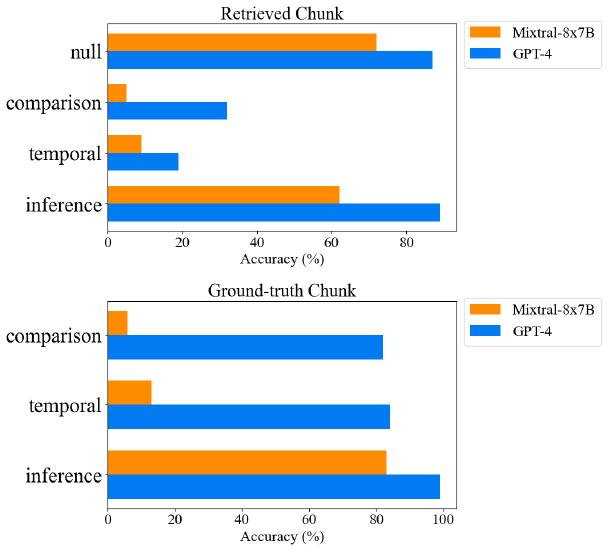

Text:  4

2024

2

0

2

n a J 7 2 ] L C . s c [ 1 v 1 9 3 5 1 . 1 0 4 2

:

v

i

X

r

a

MultiHop-RAG: Benchmarking Retrieval-Augmented Generation for Multi-Hop Queries

Yixuan Tang and Yi Yang Hong Kong University of Science and Technology {yixuantang,imyiyang}@ust.hk

Abstract

Retrieval-augmented generation (RAG) aug-

ments large language models (LLM) by re- trieving relevant knowledge, showing promis- ing potential in mitigating LLM hallucinations and enhancing response quality, thereby facil- itating the great adoption of LLMs in prac- tice. However, we find that existing RAG sys- tems are inadequate in answering multi-hop queries, which require retrieving and reasoning over multiple pieces of supporting evidence. Furthermore, to our knowledge, no existing RAG benchmarking dataset focuses on multi- hop queries. In this paper, we develop a novel dataset, MultiHop-RAG, which consists of a knowledge base, a large collection of multi- hop queries, their ground-truth answers, and t

In [116]:
for d in relevant_docs:
    if d.metadata["type"] == "image":
        plt_img_base64(d.page_content)
    elif d.metadata["type"] == "table":
        display(HTML(d.page_content))
    else:
        print("Text: ",d.page_content)

In [91]:
image_summaries[2]

'Bar charts comparing accuracy percentages of Mixtral-8x7B and GPT-4 models across categories: null, comparison, temporal, and inference. The top chart is for "Retrieved Chunk," and the bottom is "Ground-truth Chunk." GPT-4 generally shows higher accuracy.'

#### 3. Reranking and Document Selection (Leave this to the MultiModal Retriever)

#### 4. Augmented Prompt

There are many ways to write the prompt. It will basically instruct the LLM to generate result based on the {question} and the {context}.

The context is inputted from the retrieved documents from p previous step. 

In [ ]:
from langchain.prompts import ChatPromptTemplate

QA_RAG = "SIMPLE_QUESTION_ANSWER_RAG"

MM_QA_RAG = "MULTIMODAL_QUESTION_ANSWER_RAG"

prompt_type = {
    "QA_RAG" : "SIMPLE_QUESTION_ANSWER_RAG",
    "MM_QA_RAG" : "MULTIMODAL_QUESTION_ANSWER_RAG",
}

simple_rag_template = """
Answer the question based on the context below. 
If you can't answer the question, reply "I don't know".

Context: {context}

Question: {question}
"""
multimodal_rag_template = """
To define the new Prompt.

Context: {context}

Question: {question}
"""

def initPrompt(type) -> ChatPromptTemplate:
    #default
    prompt = ChatPromptTemplate.from_template(simple_rag_template)
    if type == prompt_type["QA_RAG"]: 
        prompt = ChatPromptTemplate.from_template(simple_rag_template)
    if type == prompt_type["MM_QA_RAG"]: 
        prompt = ChatPromptTemplate.from_template(multimodal_rag_template)
    return prompt

### Step 4. Generation

We now send the augmented prompt to instruct a LLM generating response to user's query. The response is finally parsed for readable. 
In this experiment, we use OpenAI model GPT3.5-Turbo. 

Note: There are many options for LLMs selection, from public to private, from simple to advance. Privacy, performance and quality should be considered to trade off. 

#### 1. QA Generation 
Using LLM to generation response to augmented query

In [75]:
# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

In [80]:
response = chain_multimodal_rag.invoke(user_query)

In [81]:
response

"Based on the provided data, here's a comparison of the performance of GPT-4 and Mixtral-8x7B:\n\n1. **Accuracy**:\n   - **Retrieved Chunk**: GPT-4 shows significantly higher accuracy compared to Mixtral-8x7B across all query types (null, comparison, temporal, inference).\n   - **Ground-truth Chunk**: GPT-4 also outperforms Mixtral-8x7B, especially in inference and comparison queries.\n\n2. **Performance Metrics**:\n   - GPT-4 consistently achieves higher accuracy percentages in both retrieved and ground-truth chunks, indicating better retrieval and reasoning capabilities.\n\n3. **Investment Advice**:\n   - **GPT-4**: Given its superior performance in accuracy and handling complex multi-hop queries, investing in technologies or applications leveraging GPT-4 could be more promising.\n   - **Mixtral-8x7B**: While it shows some capability, its lower performance suggests it may be less competitive in applications requiring high accuracy and complex reasoning.\n\nOverall, GPT-4 demonstrates

#### 2. Retrieve Topic and Relevant Articles 

In [95]:
doc_catalog = pd.DataFrame()
with open('document_catalog.pickle', 'rb') as pkl_file:
        doc_catalog = pickle.load(pkl_file)
articles = list(set([a.metadata["paper_id"] for a in relevant_docs]))

In [99]:
doc_catalog["topic"] = ["a","b","c","c"]
doc_catalog["summary"] = ["1111","222","333","3333"]

In [100]:
topics = list(set([doc_catalog["topic"].loc[i] for i, docid in enumerate(list(doc_catalog["docid"])) if docid in articles]))

In [115]:
topic_articles = [doc_catalog["filename"].loc[i][:-4] for i, docid, topic in zip(range(len(doc_catalog.index)),list(doc_catalog["docid"]),list(doc_catalog["topic"])) if docid not in articles and topic in topics]

#### 3. Retrieve Article Summary

In [125]:
articles_summary = []
topic_articles_summary = []
if articles:
    articles_summary = [doc_catalog["summary"].loc[i] for i, docid in enumerate(list(doc_catalog["docid"])) if docid in articles]
if topic_articles:
    topic_articles_summary = [doc_catalog["summary"].loc[i] for i, filename in enumerate(list(doc_catalog["filename"])) if filename[:-4] in topic_articles]

#### 4. Generate the final response

In [134]:
print("Your Query:", user_query)
print("The answer:", response)
if articles:
    print("\nYou can find the details of the answer from the following articles")
    for i in range(len(articles)):
        print("\nArticle "+str(i+1)+": "+ doc_catalog[doc_catalog["docid"]==articles[i]]["filename"].loc[0][:-4])
        print("Article Summary:\n"+articles_summary[i])
if topic_articles:
    print("\nYou seem interested in the topics:", ", ".join(topics),"\nYou may be interested in other articles in those topics below:")
    for i in range(len(topic_articles)):
        print("\nArticle "+str(i+1)+": "+topic_articles[i])
        print("Article Summary:\n"+topic_articles_summary[i])


Your Query: What is the pperformance of GPT-4 vs Mixtral?
The answer: Based on the provided data, here's a comparison of the performance of GPT-4 and Mixtral-8x7B:

1. **Accuracy**:
   - **Retrieved Chunk**: GPT-4 shows significantly higher accuracy compared to Mixtral-8x7B across all query types (null, comparison, temporal, inference).
   - **Ground-truth Chunk**: GPT-4 also outperforms Mixtral-8x7B, especially in inference and comparison queries.

2. **Performance Metrics**:
   - GPT-4 consistently achieves higher accuracy percentages in both retrieved and ground-truth chunks, indicating better retrieval and reasoning capabilities.

3. **Investment Advice**:
   - **GPT-4**: Given its superior performance in accuracy and handling complex multi-hop queries, investing in technologies or applications leveraging GPT-4 could be more promising.
   - **Mixtral-8x7B**: While it shows some capability, its lower performance suggests it may be less competitive in applications requiring high accu

# III. Research Assistant Use Cases

Demonstration of Research Assistant for: 
- Answer queries
- Relevant papers: from the query and from the topic
- Summary of the recommanded papers